In [154]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn import decomposition
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
import math
import joblib

In [155]:
data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [156]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<AxesSubplot:>

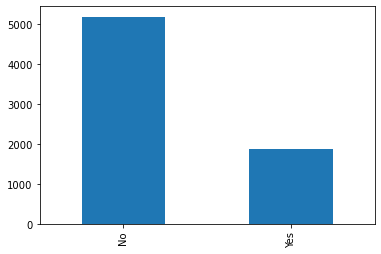

In [157]:
data['Churn'].value_counts().plot.bar()
# We can see that the data set is imbalanced, i.e., not many people have churned.

In [158]:
# Get the percentage of values in 'Churn' column
(data['Churn'].value_counts()/data['Churn'].count())*100

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

## We can see that the dataset is a little imbalanced. 
1. Churned customers = 26.53%
2. Existing customers = 73.46%

## We shall use SMOTE when fitting models for classification, and see if it provides any improvement.

# Data Pre-processing

In [159]:
# Check if data has missing values
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There are no null values in the dataset.

In [160]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### In the dataset, the 'TotalCharges' column has numerical values, but its type is 'object'. So we will convert it to float.

In [161]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### We see that there are 11 missing values in the TotalCharges column. When fitting models, we will:-
1. First split this data into test and train sets
2. Then impute the missing values in TotalCharges in the train set(if present in training set)
3. Fill the missing values in test set(if any)

# Exploratory Data Analysis

In [162]:
# Separate out the churned and existing customers
churned = data.loc[data['Churn']=='Yes']
existing = data.loc[data['Churn']=='No']

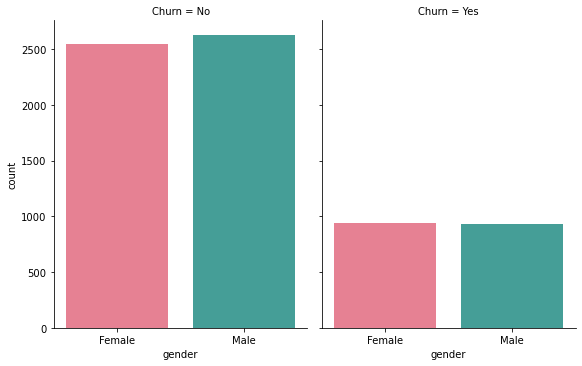

In [163]:
g = sns.catplot(x="gender", col="Churn",
                data=data, kind="count",
                height=5, aspect=0.8,palette='husl' );

### The genders are uniformally distributed in both churning and existing coustomers. Hence, gender cannot be considered a factor which determines whether a customer will churn

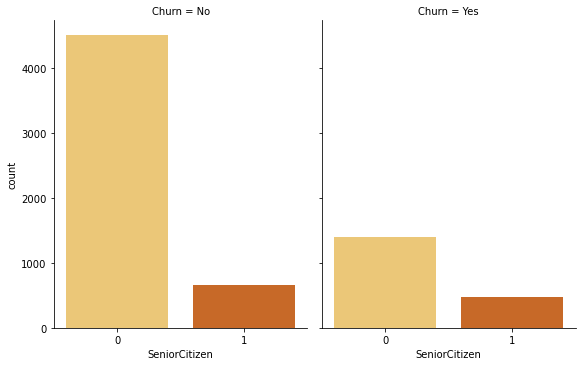

In [164]:
g = sns.catplot(x="SeniorCitizen", col="Churn",
                data=data, kind="count",
                height=5, aspect=0.8, palette='YlOrBr');

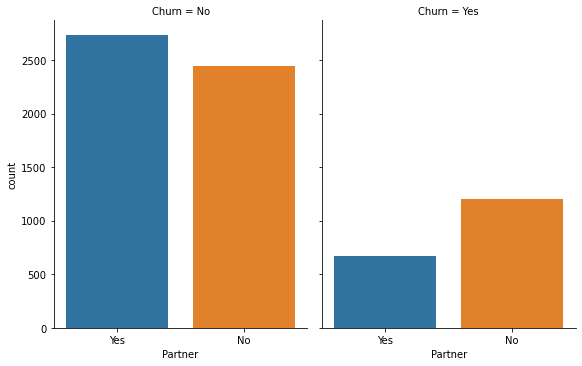

In [165]:
g = sns.catplot(x="Partner", col="Churn",
                data=data, kind="count",
                height=5, aspect=0.8);

### Most of the customers who have churned, did not have a partner.

## Analyze the numerical columns

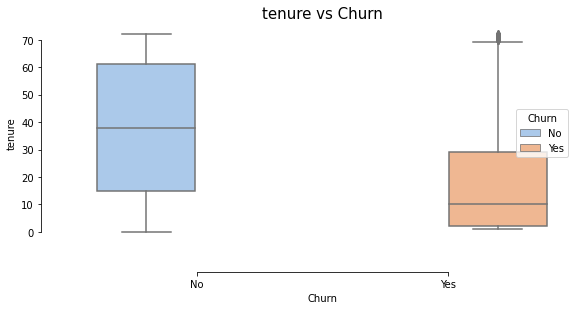

In [166]:
# Tenure vs Churn
plt.figure(figsize=(9, 4))
sns.boxplot(x="Churn", y="tenure",
            hue="Churn", palette="pastel",
            data=data).set_title("tenure vs Churn", fontsize=15)
sns.despine(offset=30, trim=True)

### We can see that 75% of the customers who churned(in the right boxplot), have stayed with the company for less than 30 months. 
### This is less than the median of existing customers group, which is around 37 months.
1. This tells us that most customers who left, did so relatively early.
2. There are some customers who left after long time, around 70 months(5.8 years). There are even some outliers, exceeding even that mark.

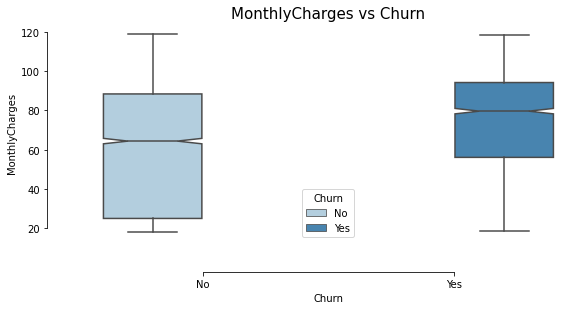

In [167]:
# MonthlyCharges vs Churn
plt.figure(figsize=(9, 4))
sns.boxplot(x="Churn", y="MonthlyCharges",
            hue="Churn", palette='Blues',
            data=data, notch=True).set_title("MonthlyCharges vs Churn", fontsize=15)
sns.despine(offset=30, trim=True)

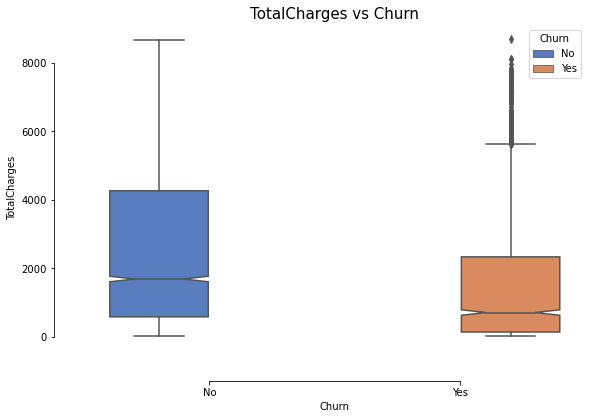

In [168]:
# TotalCharges vs Churn
plt.figure(figsize=(9, 6))
sns.boxplot(x="Churn", y="TotalCharges",
            hue="Churn", palette="muted",
            data=data, notch=True).set_title("TotalCharges vs Churn", fontsize=15)
sns.despine(offset=30, trim=True)

### Many of the customers who left, were having high monthly charges. 109 customers are even outliers in Total Charges. 
There is probably some service which costed more, but did not provide the quality as expected by the customers. 


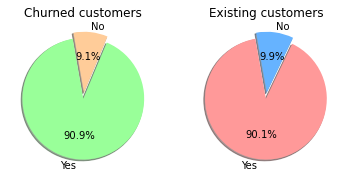

In [170]:
churned_PS = churned["PhoneService"].value_counts()
existing_PS = existing["PhoneService"].value_counts()
colors = ['#99ff99','#ffcc99']
explode = (0, 0.1)
fig1, axs = plt.subplots(1, 2)

axs[0].pie(churned_PS, labels=churned_PS.index, autopct='%1.1f%%', shadow=True, startangle=100, colors=colors, explode=explode)
axs[0].set_title('Churned customers')

colors = ['#ff9999','#66b3ff']
axs[1].pie(existing_PS, labels=existing_PS.index, autopct='%1.1f%%', shadow=True, startangle=100, colors=colors, explode=explode)
axs[1].set_title('Existing customers')

plt.show()

### Both the existing and churned customers have neraly equal distribution for phone service.

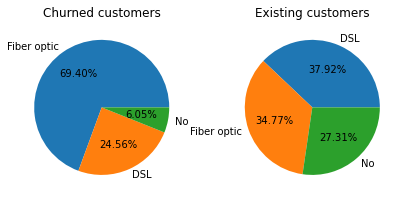

In [171]:
churned_IS = churned["InternetService"].value_counts()
existing_IS = existing["InternetService"].value_counts()

fig, axs = plt.subplots(1, 2)
fig.tight_layout()

axs[0].pie(churned_IS, labels=churned_IS.index, autopct='%1.2f%%', shadow=None)
axs[0].set_title('Churned customers')

axs[1].pie(existing_IS, labels=existing_IS.index, autopct='%1.2f%%', shadow=None)
axs[1].set_title('Existing customers')

plt.show()

In [172]:
churned_IS

Fiber optic    1297
DSL             459
No              113
Name: InternetService, dtype: int64

1. Almost 70% of the churned customers were using fiber optics for their internet service. Could this have to do something with the reason for their leaving the company services?
2. Also, nearly 94% customers who left, had even internet services. Could it be that they were dissatisfied by some of the services being provided over the internet?  

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

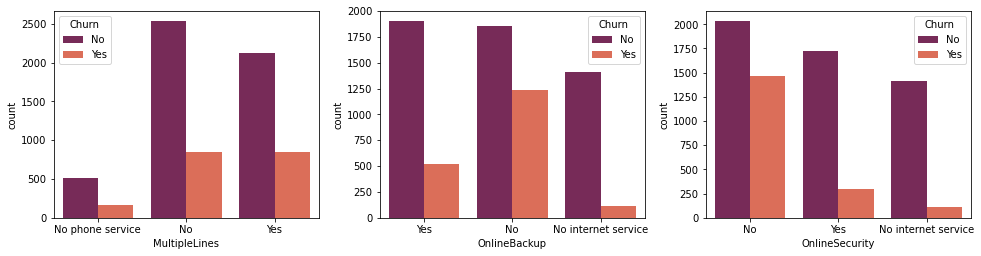

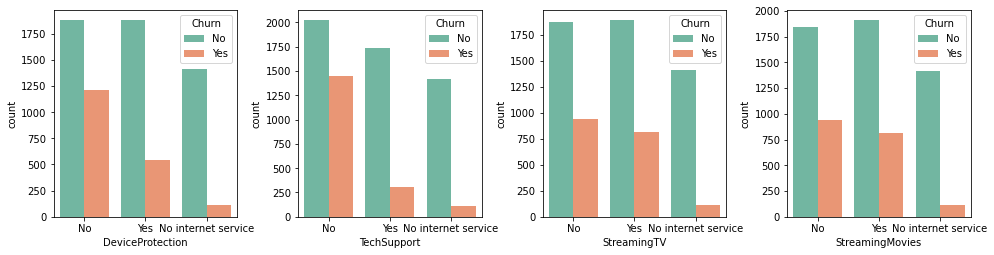

In [173]:
fig, ax =plt.subplots(nrows=1,ncols=3,figsize = (14,4))
fig.tight_layout(pad=3.0)
sns.countplot(x ='MultipleLines', hue = "Churn", data = data, ax=ax[0],palette="rocket")
sns.countplot(x ='OnlineBackup', hue = "Churn", data = data, ax=ax[1],palette="rocket")
sns.countplot(x ='OnlineSecurity', hue = "Churn", data = data, ax=ax[2],palette="rocket")

fig, ax =plt.subplots(nrows=1,ncols=4,figsize = (14,4))
fig.tight_layout(pad=3.0)
sns.countplot(x ='DeviceProtection', hue = "Churn", data = data, ax=ax[0],palette="Set2")
sns.countplot(x ='TechSupport', hue = "Churn", data = data, ax=ax[1],palette="Set2")
sns.countplot(x ='StreamingTV', hue = "Churn", data = data, ax=ax[2],palette="Set2")
sns.countplot(x ='StreamingMovies', hue = "Churn", data = data, ax=ax[3],palette="Set2")

1. Many customers who left, did not have online backup, security, even though 94% had inernet services.
2. Device Protection and tech support was also not being used in the same proportion as the customers who have stayed.

In [174]:
!pip install squarify

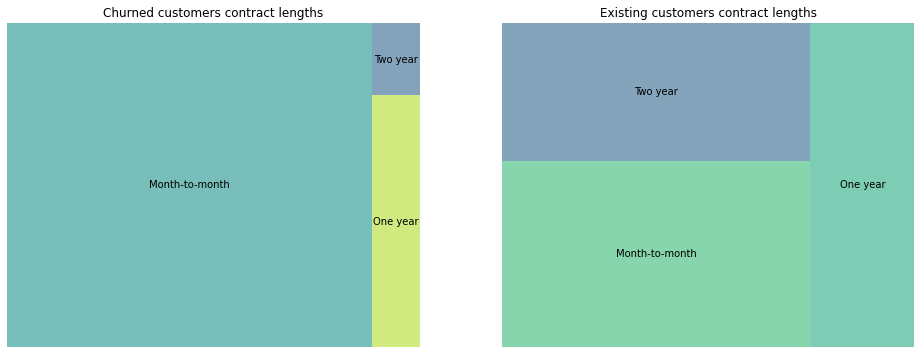

In [175]:
import squarify
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35)

x1 = churned.groupby(['Contract']).MonthlyCharges.count().sort_values(ascending=False)
axes[0].set_title('Churned customers contract lengths')
squarify.plot(sizes=x1.tolist()[:3], label=x1.index.tolist()[:3], alpha=0.6, ax=axes[0])
axes[0].axis('off')
x2 = existing.groupby(['Contract']).MonthlyCharges.count().sort_values(ascending=False)
axes[1].set_title('Existing customers contract lengths')
squarify.plot(sizes=x2.tolist()[:3], label=x2.index.tolist()[:3], alpha=0.6, ax=axes[1])
axes[1].axis('off')
plt.show()

### We can see that a very large portion of the customers who left were mostly using month-to-month contracts. This probably made it easier for them to leave, as they were not bound to the company with long term contracts.

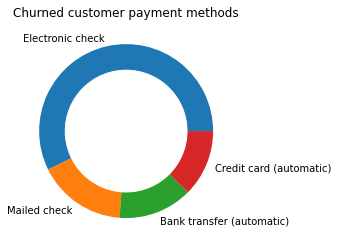

In [176]:
#fig, axes = plt.subplots(1, 2, figsize=(14, 5))

churned_paymethods=churned["PaymentMethod"].value_counts()
existing_paymethods=existing["PaymentMethod"].value_counts()
    
names=churned_paymethods.index.tolist()
plt.pie(churned_paymethods, labels=names)
#plt.show()

# add a circle at the center
my_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Churned customer payment methods")
plt.show()

# Model Fitting for classification

In [177]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### We have 11 null values in 'TotalCharges' column. To impute them, we must first:-
1. Split into test and training.
2. Impute any missing values in training set.
3. Then fit the test data accordingly.

In [178]:
# Split into test and training
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

data = data.drop(['customerID'], axis=1)
x = data.drop(['Churn'], axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Replace the null values in 'TotalCharges' with mean value
train_mean = X_train['TotalCharges'].mean()
X_train['TotalCharges'].fillna(train_mean, inplace=True)

test_mean = X_test['TotalCharges'].mean()
X_test['TotalCharges'].fillna(test_mean, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


<AxesSubplot:>

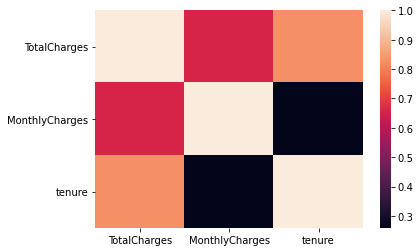

In [179]:
corr = X_train[['TotalCharges', 'MonthlyCharges', 'tenure']].corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

1. Tenure has a very positive correlation with TotalCharges, but also has almost no correlation with MonthlyCharges.

## Borderline-SMOTE oversampling

Create the transformation pipeline

In [180]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_attribs = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_attribs = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
               'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
               'Contract','PaperlessBilling','PaymentMethod']

# handle_unknown = 'ignore' is needed to produce transformed test data with same dimensions as the transformed training data.
full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown = 'ignore'), cat_attribs),
    ])

Transform the training data and test data

In [181]:
data_prepared = full_pipeline.fit_transform(X_train)
test_data = full_pipeline.fit_transform(X_test) 

Perform the SMOTE oversampling

In [182]:
# Install imblearn
import sys
!{sys.executable} -m pip install imblearn

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE(random_state=123)
X, y = oversample.fit_resample(data_prepared, y_train)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({'No': 3880, 'Yes': 1402})
Counter({'No': 3880, 'Yes': 3880})


### Our training data is well balanced now, containing equal samples from both classes(churned and existing customers)

## Principal Component Analysis to plot data

### Plot the original training data

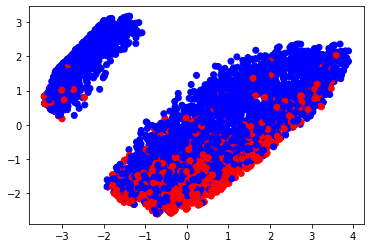

In [183]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_prepared)
data_pca = pca.transform(data_prepared)
fig, ax = plt.subplots()
colors = {'Yes':'red','No':'blue'}
ax.scatter(data_pca[:,0], data_pca[:,1], c=y_train.map(colors))
plt.show()

1. The customer information are plotted w.r.t. to the first two principal components. We can see that there are very few customers who churned(red points).
2. We also see 2 distinct clusters for customers of both kind. This suggests that there must be some very specific behaviors belonging to customers in the clusters. 

### Plot the oversampled data

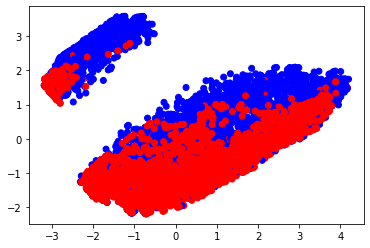

In [184]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
fig, ax = plt.subplots()
colors = {'Yes':'red','No':'blue'}
y_series = pd.Series(y)
ax.scatter(X_pca[:,0], X_pca[:,1], c=y_series.map(colors))
plt.show()

1. We can see that the churned customers(red points) are in much larger number now.
2. Also, notice that the red points are generated in those places where they were in much larger density in the first plot. Hence, Borderline SMOTE makes sure not to generate outlier like samples, as it will increase noise in the dataset.

### Loading the models that I had already trained, so that they do not have to run again on Kaggle.

In [185]:
# Load the models
RF_model = joblib.load("../input/pre-trained-models-for-customer-churn/telco_RF_model.pkl")
knn_model = joblib.load("../input/pre-trained-models-for-customer-churn/telco_knn_model.pkl")
log_model = joblib.load("../input/pre-trained-models-for-customer-churn/telco_logistic_model.pkl")
nb_model = joblib.load("../input/pre-trained-models-for-customer-churn/telco_naive_bayes_model.pkl")

RF_basemodel = joblib.load("../input/pre-trained-models-for-customer-churn/telco_RF_basemodel.pkl")
knn_basemodel = joblib.load("../input/pre-trained-models-for-customer-churn/telco_knn_basemodel.pkl")
log_basemodel = joblib.load("../input/pre-trained-models-for-customer-churn/telco_logistic_basemodel.pkl")
nb_basemodel = joblib.load("../input/pre-trained-models-for-customer-churn/telco_naive_bayes_basemodel.pkl")

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking co

# ## Since it is more important to classify the customers who might churn, we will focus more on precision and recall of the models, and select the final model based on that.

## Support Vector Machine classifier

In [186]:
def tune_svm(x,y):
  param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf']}
  grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
  grid.fit(x,y)
  return grid

svm_model = tune_svm(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   2.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   2.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   2.5s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   2.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   2.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   4.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   4.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   4.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   2.7s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   2.7s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   2.7s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   2.7s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   2.5s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   2.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   3.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   5.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   5.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   2.8s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.3min finished


In [187]:
joblib.dump(svm_model, "telco_svm_model.pkl")

['telco_svm_model.pkl']

In [257]:
y_pred = svm_model.predict(test_data)
print ("best train accuracy", svm_model.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8894329896907216
test accuracy 0.7597955706984668


In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.81      0.89      0.84      1294
         Yes       0.57      0.40      0.47       467

    accuracy                           0.76      1761
   macro avg       0.69      0.65      0.66      1761
weighted avg       0.74      0.76      0.75      1761



### SVM without SMOTE

In [194]:
grid = tune_svm(data_prepared, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.6s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   0.8s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   0.9s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   0.9s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   0.9s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=   0.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   1.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   1.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   1.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   1.0s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.5min finished


In [258]:
y_pred = grid.predict(test_data)
print ("best train accuracy", grid.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8053712981279206
test accuracy 0.7938671209540034


In [197]:
print(classification_report(y_test, y_svm_pred))

              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1294
         Yes       0.65      0.47      0.55       467

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761



## K nearest neighbors

In [199]:
# knn = KNeighborsClassifier()
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# grid.fit(X, y)

In [200]:
# knn_model = grid
# import joblib
# joblib.dump(knn_model, "telco_knn_model.pkl")

In [202]:
knn_model.best_params_

{'n_neighbors': 1}

In [259]:
y_pred = knn_model.predict(test_data)
print ("best train accuracy", knn_model.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8248711340206187
test accuracy 0.720045428733674


In [205]:
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

          No       0.84      0.77      0.80      1294
         Yes       0.48      0.58      0.52       467

    accuracy                           0.72      1761
   macro avg       0.66      0.68      0.66      1761
weighted avg       0.74      0.72      0.73      1761



### KNN Without SMOTE sampling

In [206]:
# knn = KNeighborsClassifier()
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# grid.fit(data_prepared, y_train)

In [260]:
y_pred = knn_basemodel.predict(test_data)
print ("best train accuracy", knn_basemodel.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.7938273328750645
test accuracy 0.7853492333901193


In [209]:
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

          No       0.84      0.88      0.86      1294
         Yes       0.61      0.53      0.57       467

    accuracy                           0.79      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



# Logistic Regression

In [210]:
def tune_log_reg(x,y): 
  logistic = linear_model.LogisticRegression(solver='liblinear')

  # Create regularization penalty space
  penalty = ['l1', 'l2']

  # Create regularization hyperparameter space
  C = [100, 10, 1.0, 0.1, 0.01]

  # Create hyperparameter options
  hyperparameters = dict(C=C, penalty=penalty)

  clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
  best_model = clf.fit(x, y)
  return best_model


In [211]:
#best_model = tune_log_reg(X,y)

In [212]:
# logistic_model = best_model
# import joblib
# joblib.dump(logistic_model, "telco_logistic_model.pkl")

In [213]:
log_model.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [261]:
y_pred = log_model.predict(test_data)
print ("best train accuracy", log_model.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.7516752577319588
test accuracy 0.7285633162975582


In [216]:
print(classification_report(y_test, y_logistic_pred))

              precision    recall  f1-score   support

          No       0.92      0.69      0.79      1294
         Yes       0.49      0.84      0.62       467

    accuracy                           0.73      1761
   macro avg       0.71      0.76      0.70      1761
weighted avg       0.81      0.73      0.74      1761



### Logistic regression without SMOTE sampling

In [217]:
#best_model = tune_log_reg(data_prepared,y_train)

In [262]:
y_pred = log_basemodel.predict(test_data)
print ("best train accuracy", log_basemodel.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8053720148504917
test accuracy 0.8018171493469619


In [263]:
print(classification_report(y_test, y_logistic_pred))

              precision    recall  f1-score   support

          No       0.84      0.91      0.87      1294
         Yes       0.67      0.51      0.58       467

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



# Naive Bayes Classifier

In [221]:
# #Create a Gaussian Classifier
# model = GaussianNB()

# # Train the model using the training sets
# model.fit(X,y)

In [266]:
y_naive_pred = nb_model.predict(test_data)
accuracy_score(y_test, y_naive_pred)

0.6712095400340715

In [223]:
print(classification_report(y_test, y_naive_pred))

              precision    recall  f1-score   support

          No       0.92      0.60      0.73      1294
         Yes       0.44      0.86      0.58       467

    accuracy                           0.67      1761
   macro avg       0.68      0.73      0.66      1761
weighted avg       0.79      0.67      0.69      1761



### Naive Bayes without SMOTE

In [224]:
# #Create a Gaussian Classifier
# model = GaussianNB()

# # Train the model using the training sets
# model.fit(data_prepared,y_train)

In [225]:
y_naive_pred = nb_basemodel.predict(test_data)
accuracy_score(y_test, y_naive_pred)

0.6961953435547984

In [226]:
print(classification_report(y_test, y_naive_pred))

              precision    recall  f1-score   support

          No       0.92      0.65      0.76      1294
         Yes       0.46      0.84      0.59       467

    accuracy                           0.70      1761
   macro avg       0.69      0.74      0.68      1761
weighted avg       0.80      0.70      0.71      1761



# Random Forest Classifier

In [227]:
def tune_random_forest(x,y):
  model_params = {
      'n_estimators': [50, 150, 250],
      'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
      'min_samples_split': [2, 4, 6]
  }

  # create random forest classifier model
  rf_model = RandomForestClassifier(random_state=1, oob_score = True)

  # set up grid search meta-estimator
  clf = GridSearchCV(rf_model, model_params, cv=5)

  # train the grid search meta-estimator to find the best mode
  clf.fit(x, y)
  return clf

#RF_model = tune_random_forest(X,y)

In [229]:
RF_model.best_params_

{'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}

In [267]:
y_pred = RF_model.predict(test_data)
print ("best train accuracy", RF_model.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8588917525773196
test accuracy 0.7688813174332766


In [231]:
print(classification_report(y_test, y_forest_pred))

              precision    recall  f1-score   support

          No       0.84      0.85      0.84      1294
         Yes       0.57      0.55      0.56       467

    accuracy                           0.77      1761
   macro avg       0.70      0.70      0.70      1761
weighted avg       0.77      0.77      0.77      1761



### RF without SMOTE

In [232]:
#RF_basemodel = tune_random_forest(data_prepared,y_train)

In [268]:
y_pred = RF_basemodel.predict(test_data)
print ("best train accuracy", RF_basemodel.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.7978007367908029
test accuracy 0.7978421351504826


In [235]:
print(classification_report(y_test, y_forest_pred))

              precision    recall  f1-score   support

          No       0.83      0.90      0.87      1294
         Yes       0.65      0.50      0.57       467

    accuracy                           0.80      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761



# Neural Network Classifier

In [236]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []

    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment

    return layers

def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))

    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(1, activation=activation_func))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["accuracy"]) #note: metrics could also be 'mse'

    return model

#Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = False)

activation_funcs = ['sigmoid', 'relu', 'tanh']
#loss_funcs = ['binary_crossentropy','hinge']
param_grid = dict(n_layers=[2,3], first_layer_nodes = [64,32,16], last_layer_nodes = [4], 
                  activation_func = activation_funcs, batch_size = [100], epochs = [20,60])
MLP = GridSearchCV(estimator = model, param_grid = param_grid)
MLP.fit(X,y)

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6f57bbbbd0>,
             param_grid={'activation_func': ['sigmoid', 'relu', 'tanh'],
                         'batch_size': [100], 'epochs': [20, 60],
                         'first_layer_nodes': [64, 32, 16],
                         'last_layer_nodes': [4], 'n_layers': [2, 3]})

In [238]:
MLP.best_params_

{'activation_func': 'relu',
 'batch_size': 100,
 'epochs': 60,
 'first_layer_nodes': 64,
 'last_layer_nodes': 4,
 'n_layers': 3}

In [269]:
y_pred = MLP.predict(test_data)
print ("best train accuracy", MLP.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.760567021369934
test accuracy 0.7228847245883021


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [240]:
print(classification_report(y_test, y_mlp_pred))

              precision    recall  f1-score   support

          No       0.78      0.86      0.82      1294
         Yes       0.47      0.34      0.40       467

    accuracy                           0.72      1761
   macro avg       0.63      0.60      0.61      1761
weighted avg       0.70      0.72      0.71      1761



### Neural Network without SMOTE

In [241]:
#Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = False)

activation_funcs = ['sigmoid', 'relu', 'tanh']
#loss_funcs = ['binary_crossentropy','hinge']
param_grid = dict(n_layers=[2,3], first_layer_nodes = [64,32,16], last_layer_nodes = [4], 
                  activation_func = activation_funcs, batch_size = [100], epochs = [20,60])
base_mlp = GridSearchCV(estimator = model, param_grid = param_grid)
base_mlp.fit(data_prepared, y_train)

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6ef85d5750>,
             param_grid={'activation_func': ['sigmoid', 'relu', 'tanh'],
                         'batch_size': [100], 'epochs': [20, 60],
                         'first_layer_nodes': [64, 32, 16],
                         'last_layer_nodes': [4], 'n_layers': [2, 3]})

In [270]:
# Classification accuracy on test data
y_pred = base_mlp.predict(test_data)
print ("best train accuracy", base_mlp.best_score_)
print ("test accuracy", accuracy_score(y_test, y_pred))

best train accuracy 0.8057509899139405
test accuracy 0.8086314593980692


# Precision Recall AUC plot

In [244]:
# Create the SVM model with the best parameters again, as 'probability=True' was not there while hyperparameter tuning,
# which is needed for the function 'predict_proba'. 
print (svm_model.best_params_)
print (svm_basemodel.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [245]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, gamma=1, probability=True).fit(X,y)
svm_base = SVC(kernel='rbf', C=10, gamma=0.01, probability=True).fit(data_prepared,y_train)

In [246]:
y_svm_pred = svm.predict(test_data)
accuracy_score(y_test, y_svm_pred)

0.7597955706984668

In [247]:
y_svm_pred = svm_base.predict(test_data)
accuracy_score(y_test, y_svm_pred)

0.7938671209540034

In [248]:
pred_prob1 = RF_model.predict_proba(test_data)
pred_prob2 = knn_model.predict_proba(test_data)
pred_prob3 = log_model.predict_proba(test_data)
pred_prob4 = nb_model.predict_proba(test_data)
pred_prob5 = svm.predict_proba(test_data)
pred_prob6 = MLP.predict_proba(test_data)

pred_baseprob1 = RF_basemodel.predict_proba(test_data)
pred_baseprob2 = knn_basemodel.predict_proba(test_data)
pred_baseprob3 = log_basemodel.predict_proba(test_data)
pred_baseprob4 = nb_basemodel.predict_proba(test_data)
pred_baseprob5 = svm_base.predict_proba(test_data)
pred_baseprob6 = base_mlp.predict_proba(test_data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


## Precision Recall Curves

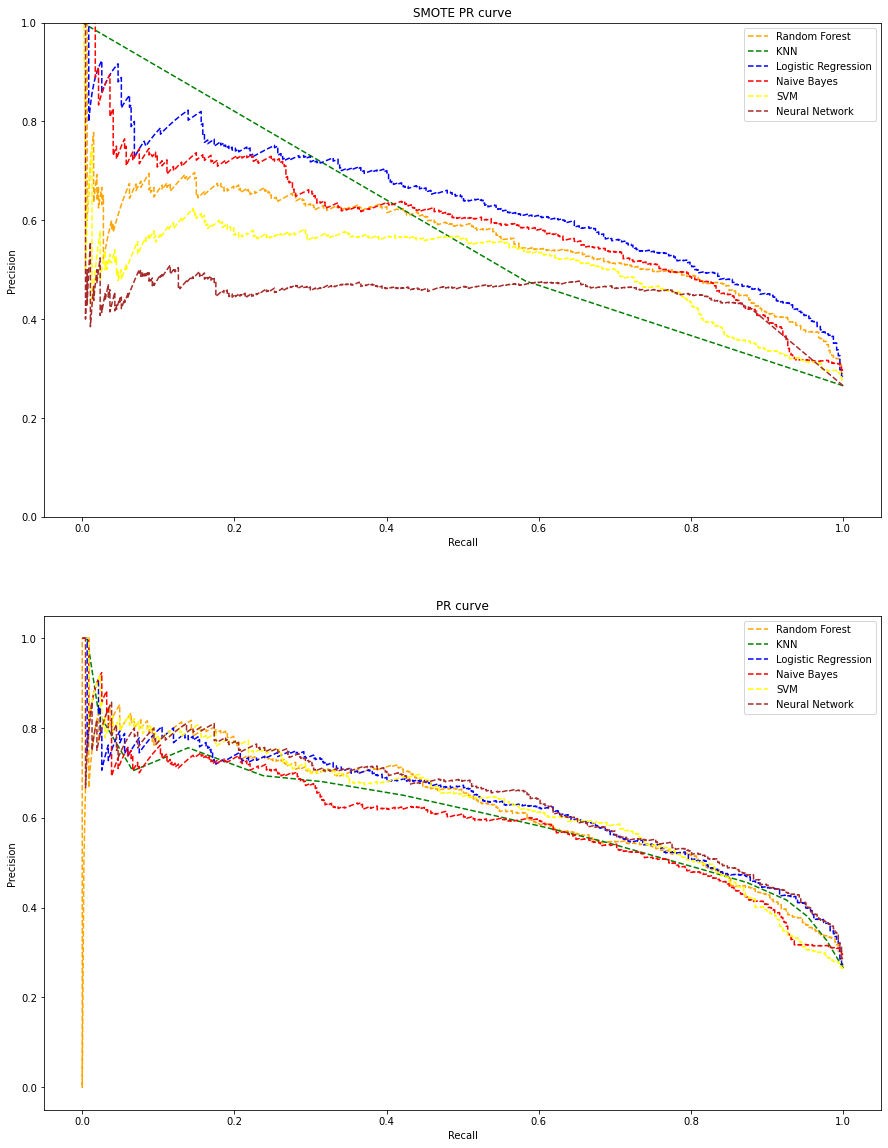

In [249]:
lr_precision1, lr_recall1, _ = precision_recall_curve(y_test, pred_prob1[:,1], pos_label='Yes')
lr_precision2, lr_recall2, _ = precision_recall_curve(y_test, pred_prob2[:,1], pos_label='Yes')
lr_precision3, lr_recall3, _ = precision_recall_curve(y_test, pred_prob3[:,1], pos_label='Yes')
lr_precision4, lr_recall4, _ = precision_recall_curve(y_test, pred_prob4[:,1], pos_label='Yes')
lr_precision5, lr_recall5, _ = precision_recall_curve(y_test, pred_prob5[:,1], pos_label='Yes')
lr_precision6, lr_recall6, _ = precision_recall_curve(y_test, pred_prob6[:,1], pos_label='Yes')

lr_precision7, lr_recall7, _ = precision_recall_curve(y_test, pred_baseprob1[:,1], pos_label='Yes')
lr_precision8, lr_recall8, _ = precision_recall_curve(y_test, pred_baseprob2[:,1], pos_label='Yes')
lr_precision9, lr_recall9, _ = precision_recall_curve(y_test, pred_baseprob3[:,1], pos_label='Yes')
lr_precision10, lr_recall10, _ = precision_recall_curve(y_test, pred_baseprob4[:,1], pos_label='Yes')
lr_precision11, lr_recall11, _ = precision_recall_curve(y_test, pred_baseprob5[:,1], pos_label='Yes')
lr_precision12, lr_recall12, _ = precision_recall_curve(y_test, pred_baseprob6[:,1], pos_label='Yes')

fig, axes = plt.subplots(2, 1, figsize=(15,20))
axes[0].plot(lr_recall1, lr_precision1, linestyle='--',color='orange', label='Random Forest')
axes[0].plot(lr_recall2, lr_precision2, linestyle='--',color='green', label='KNN')
axes[0].plot(lr_recall3, lr_precision3, linestyle='--',color='blue', label='Logistic Regression')
axes[0].plot(lr_recall4, lr_precision4, linestyle='--',color='red', label='Naive Bayes')
axes[0].plot(lr_recall5, lr_precision5, linestyle='--',color='yellow', label='SVM')
axes[0].plot(lr_recall6, lr_precision6, linestyle='--',color='brown', label='Neural Network')
axes[0].set_ylim([0.0, 1])
# title
axes[0].set_title('SMOTE PR curve')
# x label
axes[0].set_xlabel('Recall')
# y label
axes[0].set_ylabel('Precision')
axes[0].legend(loc='best')

axes[1].plot(lr_recall7, lr_precision7, linestyle='--',color='orange', label='Random Forest')
axes[1].plot(lr_recall8, lr_precision8, linestyle='--',color='green', label='KNN')
axes[1].plot(lr_recall9, lr_precision9, linestyle='--',color='blue', label='Logistic Regression')
axes[1].plot(lr_recall10, lr_precision10, linestyle='--',color='red', label='Naive Bayes')
axes[1].plot(lr_recall11, lr_precision11, linestyle='--',color='yellow', label='SVM')
axes[1].plot(lr_recall12, lr_precision12, linestyle='--',color='brown', label='Neural Network')

# title
axes[1].set_title('PR curve')
# x label
axes[1].set_xlabel('Recall')
# y label
axes[1].set_ylabel('Precision')
axes[1].legend(loc='best')

### We can see that the models are performing better when we are NOT doing BorderlineSMOTE sampling.
### Hence, we will continue with the models trained on the regular dataset(basemodels).

### Also, the probabilities generated by SVM and Random forest models can be calibrated by the 'CalibratedClassifierCV' method from sklearn.

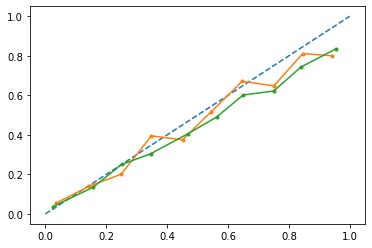

In [250]:
# reliability diagram
fop1, mpv1 = calibration_curve(y_test, pred_baseprob1[:,1], n_bins=10, normalize=True)
fop2, mpv2 = calibration_curve(y_test, pred_baseprob2[:,1], n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv1, fop1, marker='.')
pyplot.plot(mpv2, fop2, marker='.')
pyplot.show()

### We can see that the both curves are mostly under the curve, meaning that the models have over-forecast i.e., the probabilites are too large.

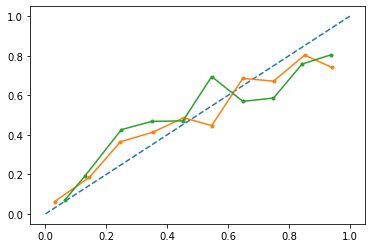

In [251]:
rf_cal = RF_basemodel.best_estimator_
rf_calibrated = CalibratedClassifierCV(rf_cal, method='sigmoid', cv=5)
rf_calibrated.fit(data_prepared, y_train)
# predict probabilities
probs_rf = rf_calibrated.predict_proba(test_data)[:, 1]
# reliability diagram
fop3, mpv3 = calibration_curve(y_test, probs_rf, n_bins=10, normalize=True)

svm_cal = svm_basemodel.best_estimator_
svm_calibrated = CalibratedClassifierCV(svm_cal, method='sigmoid', cv=5)
svm_calibrated.fit(data_prepared, y_train)
# predict probabilities
probs_svm = svm_calibrated.predict_proba(test_data)[:, 1]
# reliability diagram
fop4, mpv4 = calibration_curve(y_test, probs_svm, n_bins=10, normalize=True)

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv3, fop3, marker='.')
pyplot.plot(mpv4, fop4, marker='.')
pyplot.show()

### After calibration, we can see that parts of the curves are both above and below the base curve, making them much more balanced.
### Let's make a new PR curve with the calibrated probabilities:-

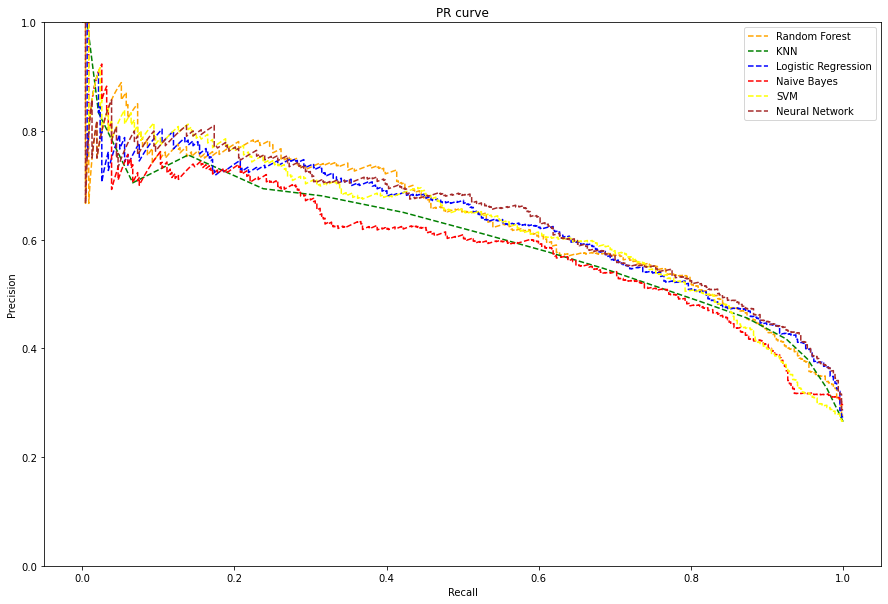

In [252]:
lr_precision7, lr_recall7, _ = precision_recall_curve(y_test, probs_rf, pos_label='Yes')
lr_precision8, lr_recall8, _ = precision_recall_curve(y_test, pred_baseprob2[:,1], pos_label='Yes')
lr_precision9, lr_recall9, _ = precision_recall_curve(y_test, pred_baseprob3[:,1], pos_label='Yes')
lr_precision10, lr_recall10, _ = precision_recall_curve(y_test, pred_baseprob4[:,1], pos_label='Yes')
lr_precision11, lr_recall11, _ = precision_recall_curve(y_test, probs_svm, pos_label='Yes')
lr_precision12, lr_recall12, _ = precision_recall_curve(y_test, pred_baseprob6[:,1], pos_label='Yes')

#fig, axes = plt.subplots(2, 1, figsize=(12, 16))
plt.figure(figsize=(15,10))
plt.plot(lr_recall7, lr_precision7, linestyle='--',color='orange', label='Random Forest')
plt.plot(lr_recall8, lr_precision8, linestyle='--',color='green', label='KNN')
plt.plot(lr_recall9, lr_precision9, linestyle='--',color='blue', label='Logistic Regression')
plt.plot(lr_recall10, lr_precision10, linestyle='--',color='red', label='Naive Bayes')
plt.plot(lr_recall11, lr_precision11, linestyle='--',color='yellow', label='SVM')
plt.plot(lr_recall12, lr_precision12, linestyle='--',color='brown', label='Neural Network')
plt.ylim([0.0, 1])
# title
plt.title('PR curve')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')
plt.legend(loc='best')

## Voting Classifier

### We can also employ an ensemble learning method, and compare its performance with the previous models.

In [253]:
a = y_test.to_list()
pred_base1 = RF_basemodel.predict(test_data)
pred_base2 = knn_basemodel.predict(test_data)
pred_base3 = log_basemodel.predict(test_data)
pred_base4 = nb_basemodel.predict(test_data)
pred_base5 = svm_base.predict(test_data)
pred_base6 = base_mlp.predict(test_data)

auc_score7 = round(auc(lr_recall7, lr_precision7),2)
rf_f1 = round(f1_score(a, pred_base2, pos_label='Yes'),2)

auc_score8 = round(auc(lr_recall8, lr_precision8),2)
knn_f1 = round(f1_score(a, pred_base2, pos_label='Yes'),2)

auc_score9 = round(auc(lr_recall9, lr_precision9),2)
log_reg_f1 = round(f1_score(a, pred_base3, pos_label='Yes'),2)

auc_score10 = round(auc(lr_recall10, lr_precision10),2)
nb_f1 = round(f1_score(a, pred_base4, pos_label='Yes'),2)

auc_score11 = round(auc(lr_recall11, lr_precision11),2)
svm_f1 = round(f1_score(a, pred_base5, pos_label='Yes'),2)

auc_score12 = round(auc(lr_recall12, lr_precision12),2)
mlp_f1 = round(f1_score(a, pred_base6, pos_label='Yes'),2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [254]:
voting_clf = VotingClassifier(estimators=[('RF', RF_model.best_estimator_), ('knn', knn_model.best_estimator_), ('LogReg', log_model.best_estimator_), ('NB', nb_model),
                                          ('SVM', svm_base)], voting='soft')
voting_clf.fit(data_prepared, y_train)
preds = voting_clf.predict(test_data)

a = y_test.to_list()
b = preds.tolist()
acc = accuracy_score(a, b)
f1 = round(f1_score(a, b, pos_label='Yes'),2)

# PR AUC score
probs = voting_clf.predict_proba(test_data)
model_probs = probs[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, model_probs, pos_label='Yes')
auc_score = round(auc(recall, precision),2)
print ("Statistics for the voting classsifier:-")
print("Accuracy is: " + str(acc))
print("F1 Score is: " + str(f1))
print('Voting classifier PR AUC: %.3f' % auc_score)

Statistics for the voting classsifier:-
Accuracy is: 0.7756956274843839
F1 Score is: 0.59
Voting classifier PR AUC: 0.630


### Plot the F1 scores and Precision-Recall AUC value:-

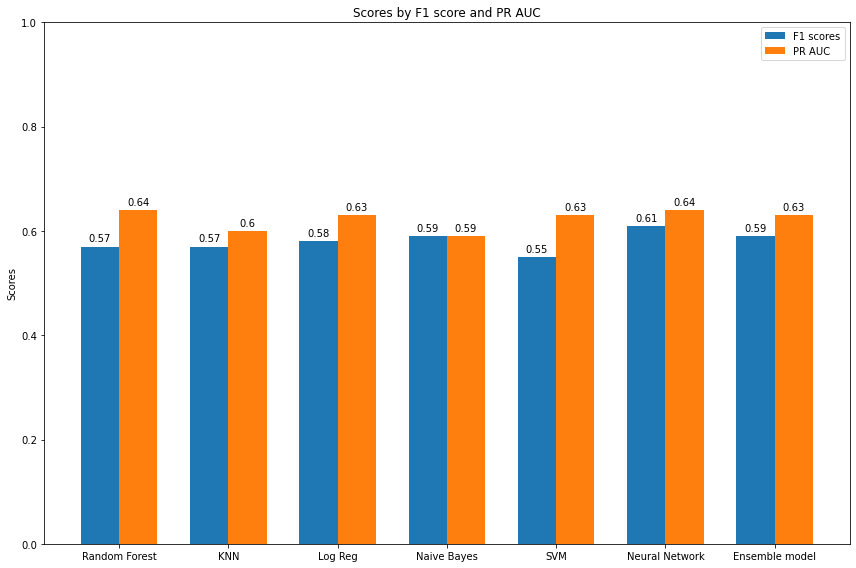

In [255]:
models = ['Random Forest', 'KNN', 'Log Reg', 'Naive Bayes', 'SVM', 'Neural Network', 'Ensemble model']
F1_scores = [rf_f1, knn_f1, log_reg_f1, nb_f1, svm_f1, mlp_f1, f1]
pr_auc = [auc_score7, auc_score8, auc_score9, auc_score10, auc_score11, auc_score12, auc_score]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, F1_scores, width, label='F1 scores')
rects2 = ax.bar(x + width/2, pr_auc, width, label='PR AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
#fig.figure()
ax.set_ylim([0.0, 1])
ax.set_ylabel('Scores')
ax.set_title('Scores by F1 score and PR AUC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='best')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.show()

## Out of all the 7 models trained, the neural network model is providing the best combination of PR AUC, and F1 scores. Hence, we can finalize that as the best algorithm for this dataset.

In [256]:
y_mlp_pred = base_mlp.predict(test_data)

print("Statistics for the neurak network model:-")
print("Accuracy is: " + str(accuracy_score(y_test, y_mlp_pred)))
print("F1 Score is: " + str(mlp_f1))
print('Voting classifier PR AUC: %.3f' % auc_score12)

Statistics for the neurak network model:-
Accuracy is: 0.8086314593980692
F1 Score is: 0.61
Voting classifier PR AUC: 0.640


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
